In [1]:
import glob

import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

from unseen import fileio
from unseen import independence
from unseen import bias_correction
from unseen import similarity
from unseen import general_utils
from unseen import stability

Matplotlib is building the font cache; this may take a moment.


In [54]:
from importlib import reload

In [48]:
from unseen import moments

In [56]:
reload(moments)

<module 'unseen.moments' from '/home/599/dbi599/unseen/unseen/moments.py'>

## Obs

In [142]:
#agcd_file = '/g/data/ia39/agcd/post-processed/data/agcd_v2_precip_total_cafe-grid_monthly_1900-2020.zarr.zip'

In [2]:
agcd_files = glob.glob('/g/data/zv2/agcd/v2-0-1/precip/total/r005/01month/agcd_v2-0-1_precip_total_r005_monthly_*.nc')
agcd_files.sort()
agcd_files

['/g/data/zv2/agcd/v2-0-1/precip/total/r005/01month/agcd_v2-0-1_precip_total_r005_monthly_1900.nc',
 '/g/data/zv2/agcd/v2-0-1/precip/total/r005/01month/agcd_v2-0-1_precip_total_r005_monthly_1901.nc',
 '/g/data/zv2/agcd/v2-0-1/precip/total/r005/01month/agcd_v2-0-1_precip_total_r005_monthly_1902.nc',
 '/g/data/zv2/agcd/v2-0-1/precip/total/r005/01month/agcd_v2-0-1_precip_total_r005_monthly_1903.nc',
 '/g/data/zv2/agcd/v2-0-1/precip/total/r005/01month/agcd_v2-0-1_precip_total_r005_monthly_1904.nc',
 '/g/data/zv2/agcd/v2-0-1/precip/total/r005/01month/agcd_v2-0-1_precip_total_r005_monthly_1905.nc',
 '/g/data/zv2/agcd/v2-0-1/precip/total/r005/01month/agcd_v2-0-1_precip_total_r005_monthly_1906.nc',
 '/g/data/zv2/agcd/v2-0-1/precip/total/r005/01month/agcd_v2-0-1_precip_total_r005_monthly_1907.nc',
 '/g/data/zv2/agcd/v2-0-1/precip/total/r005/01month/agcd_v2-0-1_precip_total_r005_monthly_1908.nc',
 '/g/data/zv2/agcd/v2-0-1/precip/total/r005/01month/agcd_v2-0-1_precip_total_r005_monthly_1909.nc',


In [4]:
agcd_ds = fileio.open_dataset(agcd_files,
    variables=['pr'],
    shapefile='wheatbelt.zip',
    spatial_agg='mean',
    time_freq='A-DEC',
    time_agg='sum',
    input_freq='M',
    metadata_file='../../config/dataset_agcd_monthly.yml',
    complete_time_agg_periods=True
)

In [7]:
print(agcd_ds)

<xarray.Dataset>
Dimensions:  (time: 123)
Coordinates:
  * time     (time) object 1900-12-31 00:00:00 ... 2022-12-31 00:00:00
Data variables:
    pr       (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/33)
    geospatial_lat_min:        -44.525
    geospatial_lat_max:        -9.975
    geospatial_lon_min:        111.975
    geospatial_lon_max:        156.275
    time_coverage_start:       1900-01-01T00:00:00
    date_created:              2020-08-27T21:49:15.867624
    ...                        ...
    licence:                   Data Licence: The grid data files in this AGCD...
    description:               This AGCD data is a snapshot of the operationa...
    date_issued:               2023-05-21 22:51:24
    attribution:               Data should be cited as : Australian Bureau of...
    copyright:                 (C) Copyright Commonwealth of Australia 2023, ...
    history:                    


In [8]:
agcd_ds = agcd_ds.compute()

In [9]:
years = agcd_ds['time'].dt.year.values
agcd_df = pd.DataFrame(index=years)
agcd_df['pr'] = agcd_ds['pr'].values

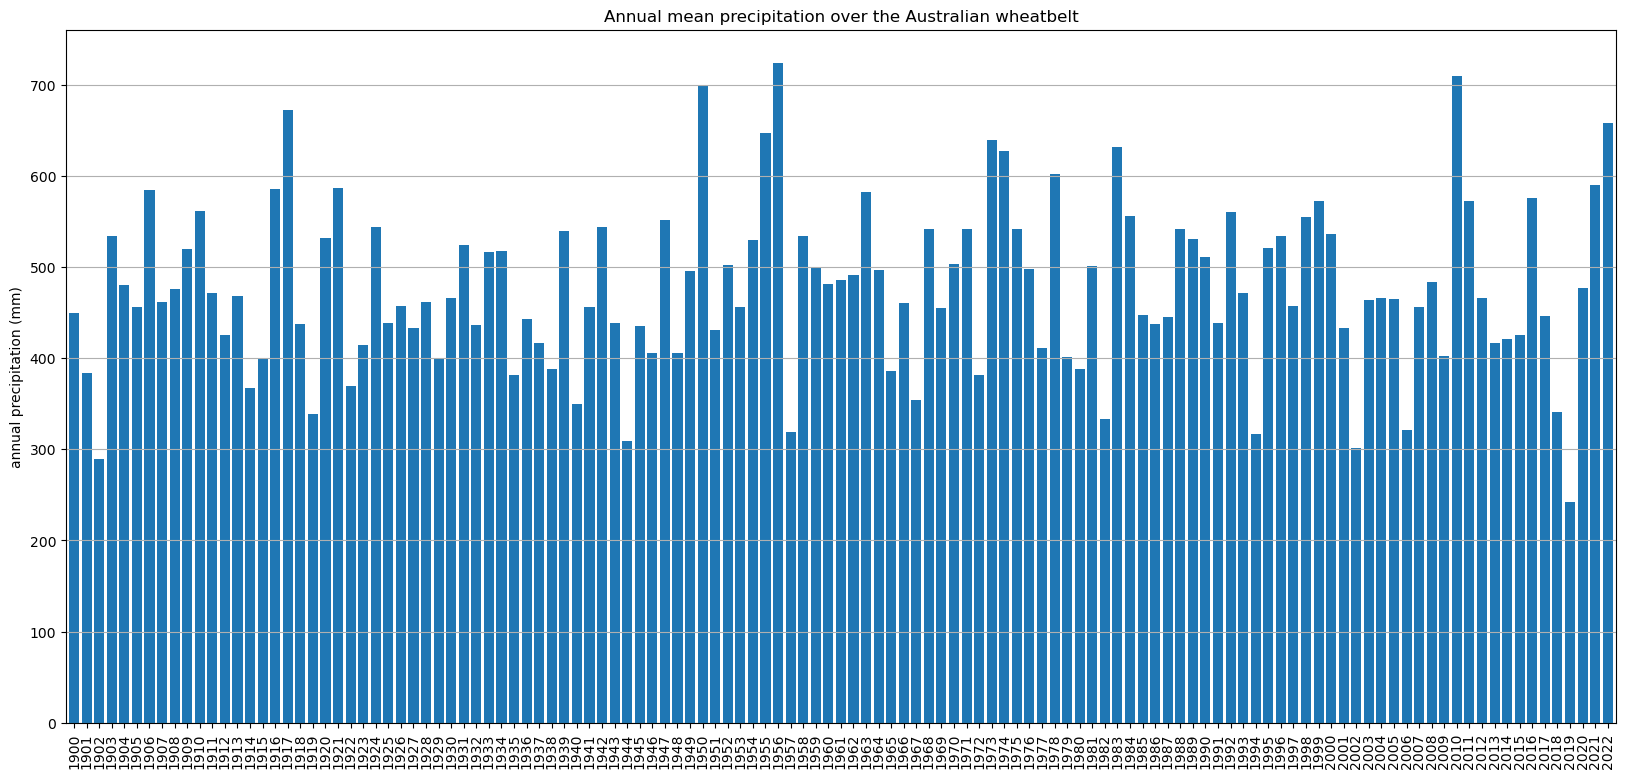

In [10]:
agcd_df['pr'].plot.bar(figsize=[20, 9], width=0.8)
#plt.axhline(mean_rainfall, color='0.5', linestyle='--')
plt.ylabel('annual precipitation (mm)')
plt.title(f'Annual mean precipitation over the Australian wheatbelt')
plt.grid(axis='y')

plt.savefig('observational_record.png',
            bbox_inches='tight', facecolor='white', dpi=200)

In [11]:
ranked_years = agcd_df['pr'].sort_values()
print(ranked_years.head(n=10))

2019    241.974106
1902    289.800018
2002    301.461090
1944    308.774658
1994    316.875275
1957    318.917206
2006    321.389435
1982    333.308380
1919    339.139893
2018    341.417114
Name: pr, dtype: float32


2019 was the driest year on record for Australia. Do the example UNSEEN analysis on that.

## Model

In [12]:
cafe_files1990s = glob.glob('/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-199[5,6,7,8,9]*/atmos_isobaric_daily.zarr.zip')
cafe_files2000s = glob.glob('/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-2*/atmos_isobaric_daily.zarr.zip')
cafe_files = cafe_files1990s + cafe_files2000s
cafe_files.sort()
print(cafe_files)

['/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19950501/atmos_isobaric_daily.zarr.zip', '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19951101/atmos_isobaric_daily.zarr.zip', '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19960501/atmos_isobaric_daily.zarr.zip', '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19961101/atmos_isobaric_daily.zarr.zip', '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19970501/atmos_isobaric_daily.zarr.zip', '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19971101/atmos_isobaric_daily.zarr.zip', '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19980501/atmos_isobaric_daily.zarr.zip', '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19981101/atmos_isobaric_daily.zarr.zip', '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19990501/atmos_isobaric_daily.zarr.zip', '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19991101/atmos_isobaric_daily.zarr.zip', '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20000501/atmos_isobaric_daily.zarr.zip', '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20001101/atmos_isobaric_daily.zarr.zip', '/g/data/xv83/dcfp/CAFE-f6/

In [14]:
cafe_ds = fileio.open_mfforecast(cafe_files,
    variables=['pr'],
    lat_bnds=[-44, -11],
    lon_bnds=[113, 154],
    shapefile='wheatbelt.zip',
    spatial_agg='mean',
    time_freq='A-DEC',
    time_agg='sum',
    input_freq='D',
    reset_times=True,
    metadata_file='../../config/dataset_cafe_monthly.yml',
    complete_time_agg_periods=True,
    units={'pr': 'mm day-1'},
    units_timing='middle'
)

In [15]:
print(cafe_ds)

<xarray.Dataset>
Dimensions:    (init_date: 52, lead_time: 11, ensemble: 96)
Coordinates:
  * ensemble   (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10
  * init_date  (init_date) object 1995-05-01 00:00:00 ... 2020-11-01 00:00:00
    time       (lead_time, init_date) object 1995-05-01 12:00:00 ... 2030-11-...
Data variables:
    pr         (init_date, lead_time, ensemble) float64 dask.array<chunksize=(1, 1, 96), meta=np.ndarray>
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    title:      AccessOcean-AM2


In [16]:
cafe_ds = cafe_ds.compute()

In [17]:
cafe_ds['pr'].isel({'ensemble': 1, 'init_date': 2}).values

array([         nan, 295.14444733, 322.83443544, 446.61548817,
       702.48614395, 626.8567071 , 363.21144093, 531.30252579,
       682.132782  , 379.88773751,          nan])

## Stability and stationarity

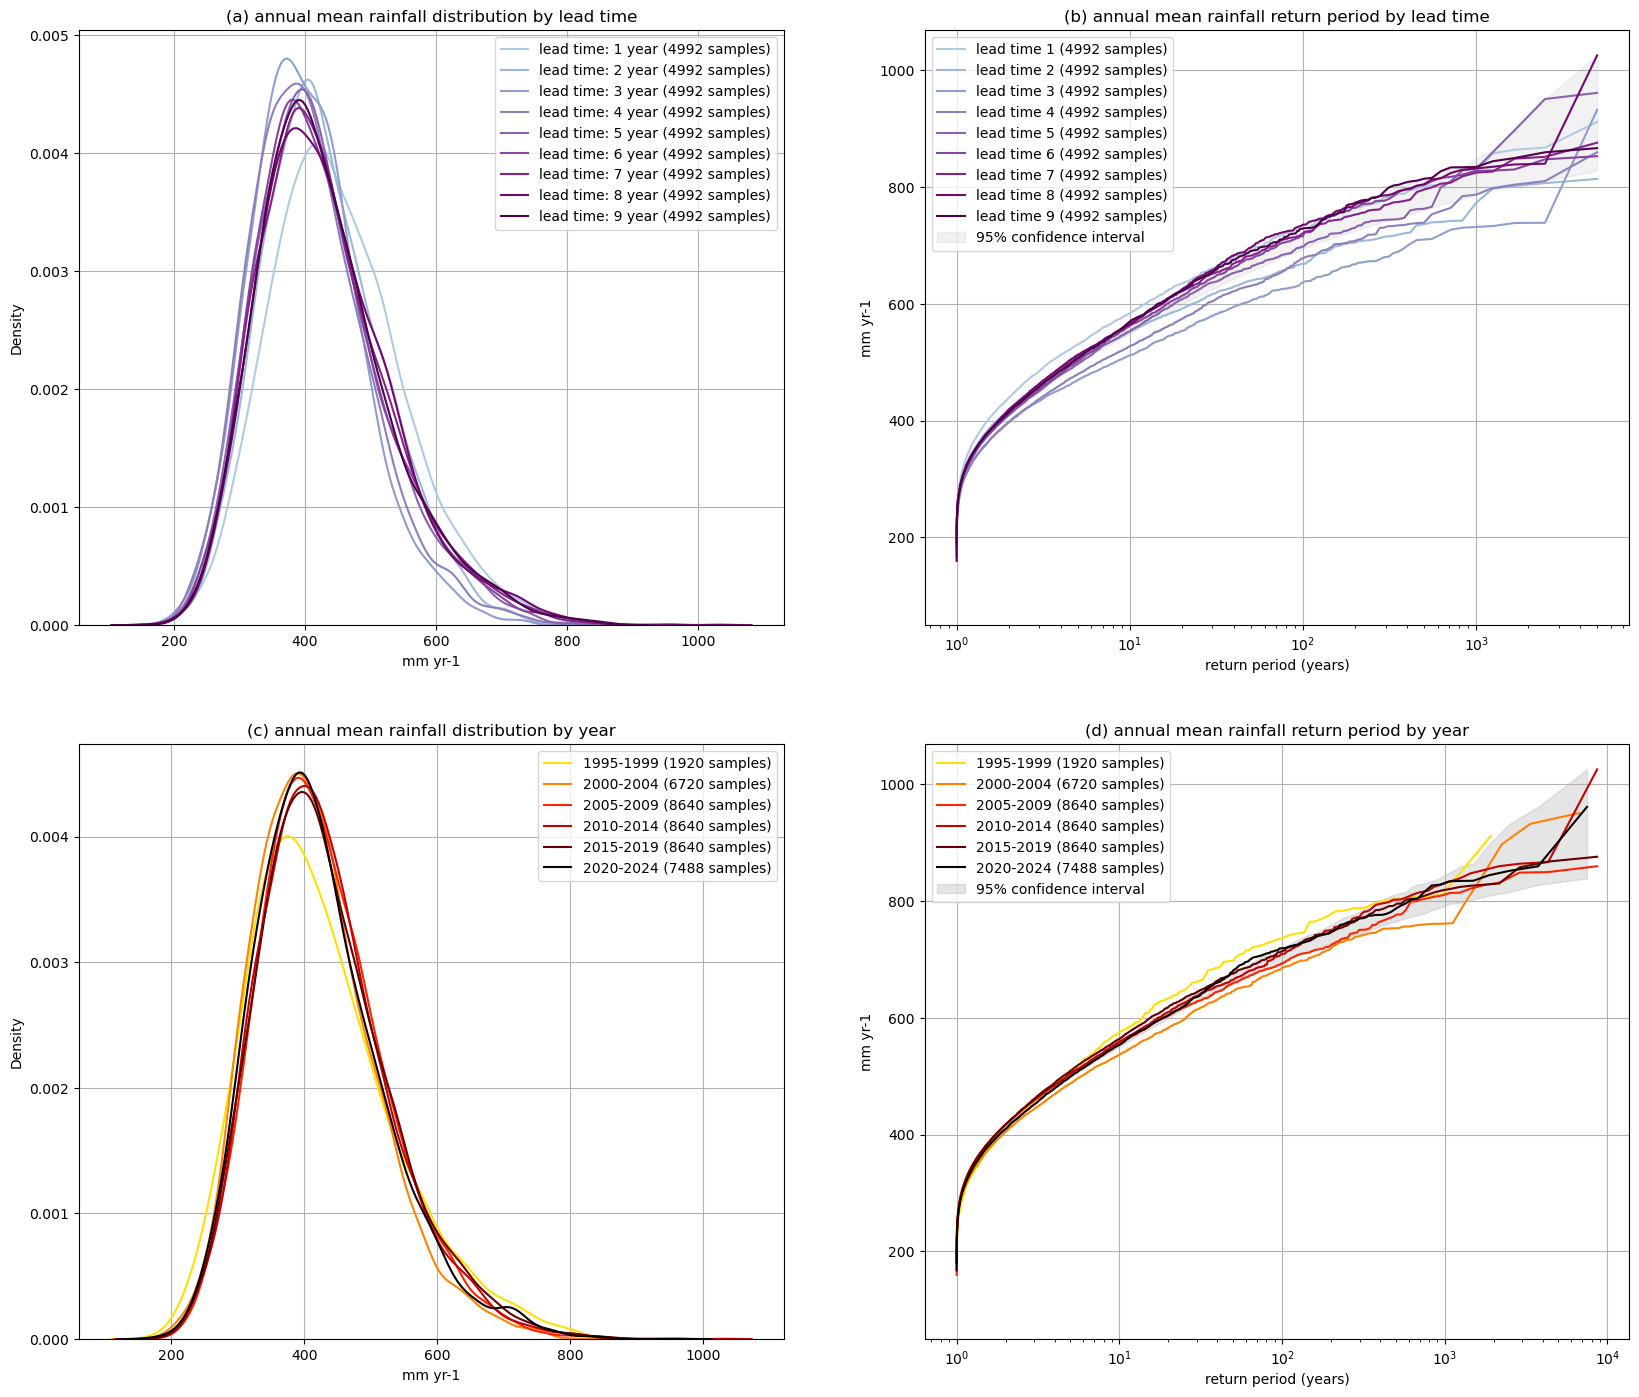

In [47]:
stability.create_plot(
    cafe_ds['pr'],
    'annual mean rainfall',
    [1995, 2000, 2005, 2010, 2015, 2020],
    outfile='wheatbelt_stability.png',
    uncertainty=True,
    return_method='empirical',
    ymax=None,
)

## Independence testing

In [18]:
mean_correlations, null_correlation_bounds = independence.run_tests(cafe_ds['pr'])

/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would corrupt indices for other variables: ['init_date', 'lead_time', 'ensemble']. This will raise an error in the future. Use `.drop_vars({'ensemble', 'sample', 'init_date', 'lead_time'})` before assigning new coordinate values.
  data.coords.update(results)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would corrupt indices for other variables: ['init_date', 'lead_time', 'ensemble']. This will raise an error in the future. Use `.drop_vars({'ensemble', 'sample', 'init_date', 'lead_time'})` before assigning new coordinate values.
  data.coords.update(results)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would cor

/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would corrupt indices for other variables: ['init_date', 'lead_time', 'ensemble']. This will raise an error in the future. Use `.drop_vars({'ensemble', 'sample', 'init_date', 'lead_time'})` before assigning new coordinate values.
  data.coords.update(results)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would corrupt indices for other variables: ['init_date', 'lead_time', 'ensemble']. This will raise an error in the future. Use `.drop_vars({'ensemble', 'sample', 'init_date', 'lead_time'})` before assigning new coordinate values.
  data.coords.update(results)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would cor

/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would corrupt indices for other variables: ['init_date', 'lead_time', 'ensemble']. This will raise an error in the future. Use `.drop_vars({'ensemble', 'sample', 'init_date', 'lead_time'})` before assigning new coordinate values.
  data.coords.update(results)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would corrupt indices for other variables: ['init_date', 'lead_time', 'ensemble']. This will raise an error in the future. Use `.drop_vars({'ensemble', 'sample', 'init_date', 'lead_time'})` before assigning new coordinate values.
  data.coords.update(results)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would cor

/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would corrupt indices for other variables: ['init_date', 'lead_time', 'ensemble']. This will raise an error in the future. Use `.drop_vars({'ensemble', 'sample', 'init_date', 'lead_time'})` before assigning new coordinate values.
  data.coords.update(results)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would corrupt indices for other variables: ['init_date', 'lead_time', 'ensemble']. This will raise an error in the future. Use `.drop_vars({'ensemble', 'sample', 'init_date', 'lead_time'})` before assigning new coordinate values.
  data.coords.update(results)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would cor

/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would corrupt indices for other variables: ['init_date', 'lead_time', 'ensemble']. This will raise an error in the future. Use `.drop_vars({'ensemble', 'sample', 'init_date', 'lead_time'})` before assigning new coordinate values.
  data.coords.update(results)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would corrupt indices for other variables: ['init_date', 'lead_time', 'ensemble']. This will raise an error in the future. Use `.drop_vars({'ensemble', 'sample', 'init_date', 'lead_time'})` before assigning new coordinate values.
  data.coords.update(results)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would cor

/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would corrupt indices for other variables: ['init_date', 'lead_time', 'ensemble']. This will raise an error in the future. Use `.drop_vars({'ensemble', 'sample', 'init_date', 'lead_time'})` before assigning new coordinate values.
  data.coords.update(results)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would corrupt indices for other variables: ['init_date', 'lead_time', 'ensemble']. This will raise an error in the future. Use `.drop_vars({'ensemble', 'sample', 'init_date', 'lead_time'})` before assigning new coordinate values.
  data.coords.update(results)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would cor

/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would corrupt indices for other variables: ['init_date', 'lead_time', 'ensemble']. This will raise an error in the future. Use `.drop_vars({'ensemble', 'sample', 'init_date', 'lead_time'})` before assigning new coordinate values.
  data.coords.update(results)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would corrupt indices for other variables: ['init_date', 'lead_time', 'ensemble']. This will raise an error in the future. Use `.drop_vars({'ensemble', 'sample', 'init_date', 'lead_time'})` before assigning new coordinate values.
  data.coords.update(results)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would cor

/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would corrupt indices for other variables: ['init_date', 'lead_time', 'ensemble']. This will raise an error in the future. Use `.drop_vars({'ensemble', 'sample', 'init_date', 'lead_time'})` before assigning new coordinate values.
  data.coords.update(results)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would corrupt indices for other variables: ['init_date', 'lead_time', 'ensemble']. This will raise an error in the future. Use `.drop_vars({'ensemble', 'sample', 'init_date', 'lead_time'})` before assigning new coordinate values.
  data.coords.update(results)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would cor

/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would corrupt indices for other variables: ['init_date', 'lead_time', 'ensemble']. This will raise an error in the future. Use `.drop_vars({'ensemble', 'sample', 'init_date', 'lead_time'})` before assigning new coordinate values.
  data.coords.update(results)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would corrupt indices for other variables: ['init_date', 'lead_time', 'ensemble']. This will raise an error in the future. Use `.drop_vars({'ensemble', 'sample', 'init_date', 'lead_time'})` before assigning new coordinate values.
  data.coords.update(results)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would cor

/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would corrupt indices for other variables: ['init_date', 'lead_time', 'ensemble']. This will raise an error in the future. Use `.drop_vars({'ensemble', 'sample', 'init_date', 'lead_time'})` before assigning new coordinate values.
  data.coords.update(results)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would corrupt indices for other variables: ['init_date', 'lead_time', 'ensemble']. This will raise an error in the future. Use `.drop_vars({'ensemble', 'sample', 'init_date', 'lead_time'})` before assigning new coordinate values.
  data.coords.update(results)
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xarray/core/common.py:605: FutureWarning: Updating MultiIndexed coordinate 'sample' would cor

In [19]:
print(mean_correlations)

{5: <xarray.DataArray (lead_time: 11)>
dask.array<mean_agg-aggregate, shape=(11,), dtype=float64, chunksize=(11,), chunktype=numpy.ndarray>
Coordinates:
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10, 11: <xarray.DataArray (lead_time: 11)>
dask.array<mean_agg-aggregate, shape=(11,), dtype=float64, chunksize=(11,), chunktype=numpy.ndarray>
Coordinates:
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10}


/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den


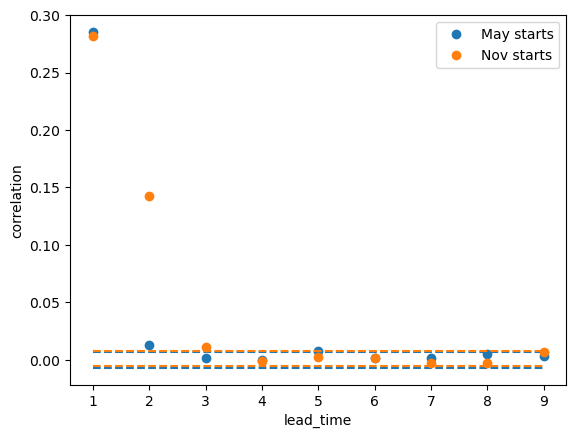

In [20]:
independence.create_plot(
    mean_correlations,
    null_correlation_bounds,
    'wheatbelt_independence.png'
)

So we should drop the first two lead times (TODO: We need a function where we can drop a different number of lead times for each init date).

In [21]:
#cafe_da_indep = cafe_ds['pr'].dropna('lead_time').sel({'lead_time': slice(3, None)})
cafe_da_indep = cafe_ds['pr'].where(cafe_ds['lead_time'] > 2)

In [22]:
print(cafe_da_indep)

<xarray.DataArray 'pr' (init_date: 52, lead_time: 11, ensemble: 96)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [265.21800262, 455.30549558, 358.15782542, ..., 542.68410959,
         514.85789812, 468.60992288],
        [334.28821798, 406.5729935 , 518.13269371, ..., 533.00896422,
         365.13987188, 422.97639652],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, .

## Bias correction

In [23]:
correction_method = 'additive'
baseline_period = ['2004-01-01', '2019-12-31']

In [24]:
bias = bias_correction.get_bias(
    cafe_da_indep,
    agcd_ds['pr'],
    correction_method,
    time_rounding='A',
    time_period=baseline_period
)
print(bias)

<xarray.DataArray 'pr' (month: 2)>
array([-28.65229904, -25.77339657])
Coordinates:
  * month    (month) int64 5 11
Attributes:
    units:                   mm yr-1
    climatological_period:   ['2004-01-01', '2019-12-31']
    bias_correction_method:  additive
    bias_correction_period:  2004-01-01-2019-12-31


In [25]:
cafe_da_bc = bias_correction.remove_bias(cafe_da_indep, bias, correction_method)

In [26]:
print(cafe_da_bc)

<xarray.DataArray 'pr' (init_date: 52, lead_time: 11, ensemble: 96)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [293.87030165, 483.95779461, 386.81012446, ..., 571.33640863,
         543.51019716, 497.26222191],
        [362.94051701, 435.22529253, 546.78499275, ..., 561.66126325,
         393.79217092, 451.62869556],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, .

In [27]:
cafe_da_bc = cafe_da_bc.compute()

In [28]:
cafe_da_bc.dropna('lead_time')

<xarray.DataArray 'pr' (init_date: 52, lead_time: 7, ensemble: 96)>
array([[[474.3500212 , 370.36106518, 293.71027128, ..., 444.56327367,
         667.47851624, 434.78871155],
        [712.58423603, 462.23924951, 588.53460239, ..., 445.39799149,
         689.55053178, 674.06546376],
        [430.21373363, 427.95933303, 361.10478078, ..., 524.85236548,
         351.02979277, 367.09627176],
        ...,
        [464.25387799, 289.41256986, 468.0911736 , ..., 474.72151282,
         621.10984636, 466.91634036],
        [293.87030165, 483.95779461, 386.81012446, ..., 571.33640863,
         543.51019716, 497.26222191],
        [362.94051701, 435.22529253, 546.78499275, ..., 561.66126325,
         393.79217092, 451.62869556]],

       [[369.31981947, 379.76966575, 478.25442018, ..., 256.49107937,
         618.69475074, 633.99750718],
        [355.98252192, 366.97660905, 463.88917887, ..., 365.14123117,
         528.25850218, 835.91066711],
        [516.19707289, 457.72218471, 402.83067428, ..., 349.91154764,
         557.91263976, 553.93218116],
...
        [565.52592939, 548.24278859, 417.90871907, ..., 314.56409763,
         344.76678924, 451.11489419],
        [393.92479796, 472.95378442, 451.40428756, ..., 454.74101281,
         550.89137069, 558.101523  ],
        [510.29294595, 411.0873527 , 445.77123424, ..., 584.22746563,
         488.08956559, 381.62325386]],

       [[418.52352413, 600.93145666, 407.98539618, ..., 432.66767158,
         328.45576735, 443.85404568],
        [420.7559496 , 359.03326974, 469.43381334, ..., 431.96081071,
         434.03995934, 454.45115288],
        [618.04722535, 460.52838432, 367.75598345, ..., 333.38420972,
         556.19094585, 399.43574641],
        ...,
        [369.45109294, 381.62442721, 323.52804973, ..., 472.88095424,
         652.00373599, 412.08487005],
        [314.86521   , 379.06822793, 414.3392131 , ..., 471.1851196 ,
         528.58077716, 548.11990739],
        [380.18376087, 418.55959777, 465.9329868 , ..., 446.53302601,
         511.91600511, 475.25507601]]])
Coordinates:
  * ensemble   (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
  * lead_time  (lead_time) int64 3 4 5 6 7 8 9
  * init_date  (init_date) object 1995-05-01 00:00:00 ... 2020-11-01 00:00:00
    time       (lead_time, init_date) object 1998-05-01 12:00:00 ... 2029-11-...
Attributes:
    units:                   mm yr-1
    bias_correction_method:  additive
    bias_correction_period:  2004-01-01-2019-12-31

## Similarity testing

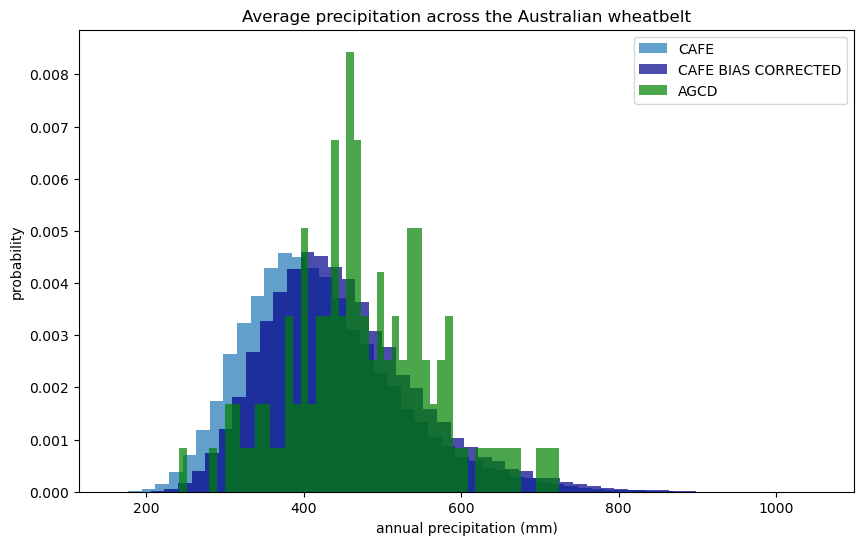

In [35]:
fig = plt.figure(figsize=[10, 6])
cafe_da_indep.plot.hist(
    bins=50, density=True, label='CAFE', alpha=0.7
)
cafe_da_bc.plot.hist(
    bins=50, density=True, label='CAFE BIAS CORRECTED', facecolor='darkblue', alpha=0.7
)
agcd_ds['pr'].plot.hist(
    bins=50, density=True, label='AGCD', facecolor='green', alpha=0.7
)
plt.xlabel('annual precipitation (mm)')
plt.ylabel('probability')
plt.title(f'Average precipitation across the Australian wheatbelt')
plt.legend()
plt.savefig('wheatbelt_precip_histogram.png',
            bbox_inches='tight', facecolor='white', dpi=200)
plt.show()

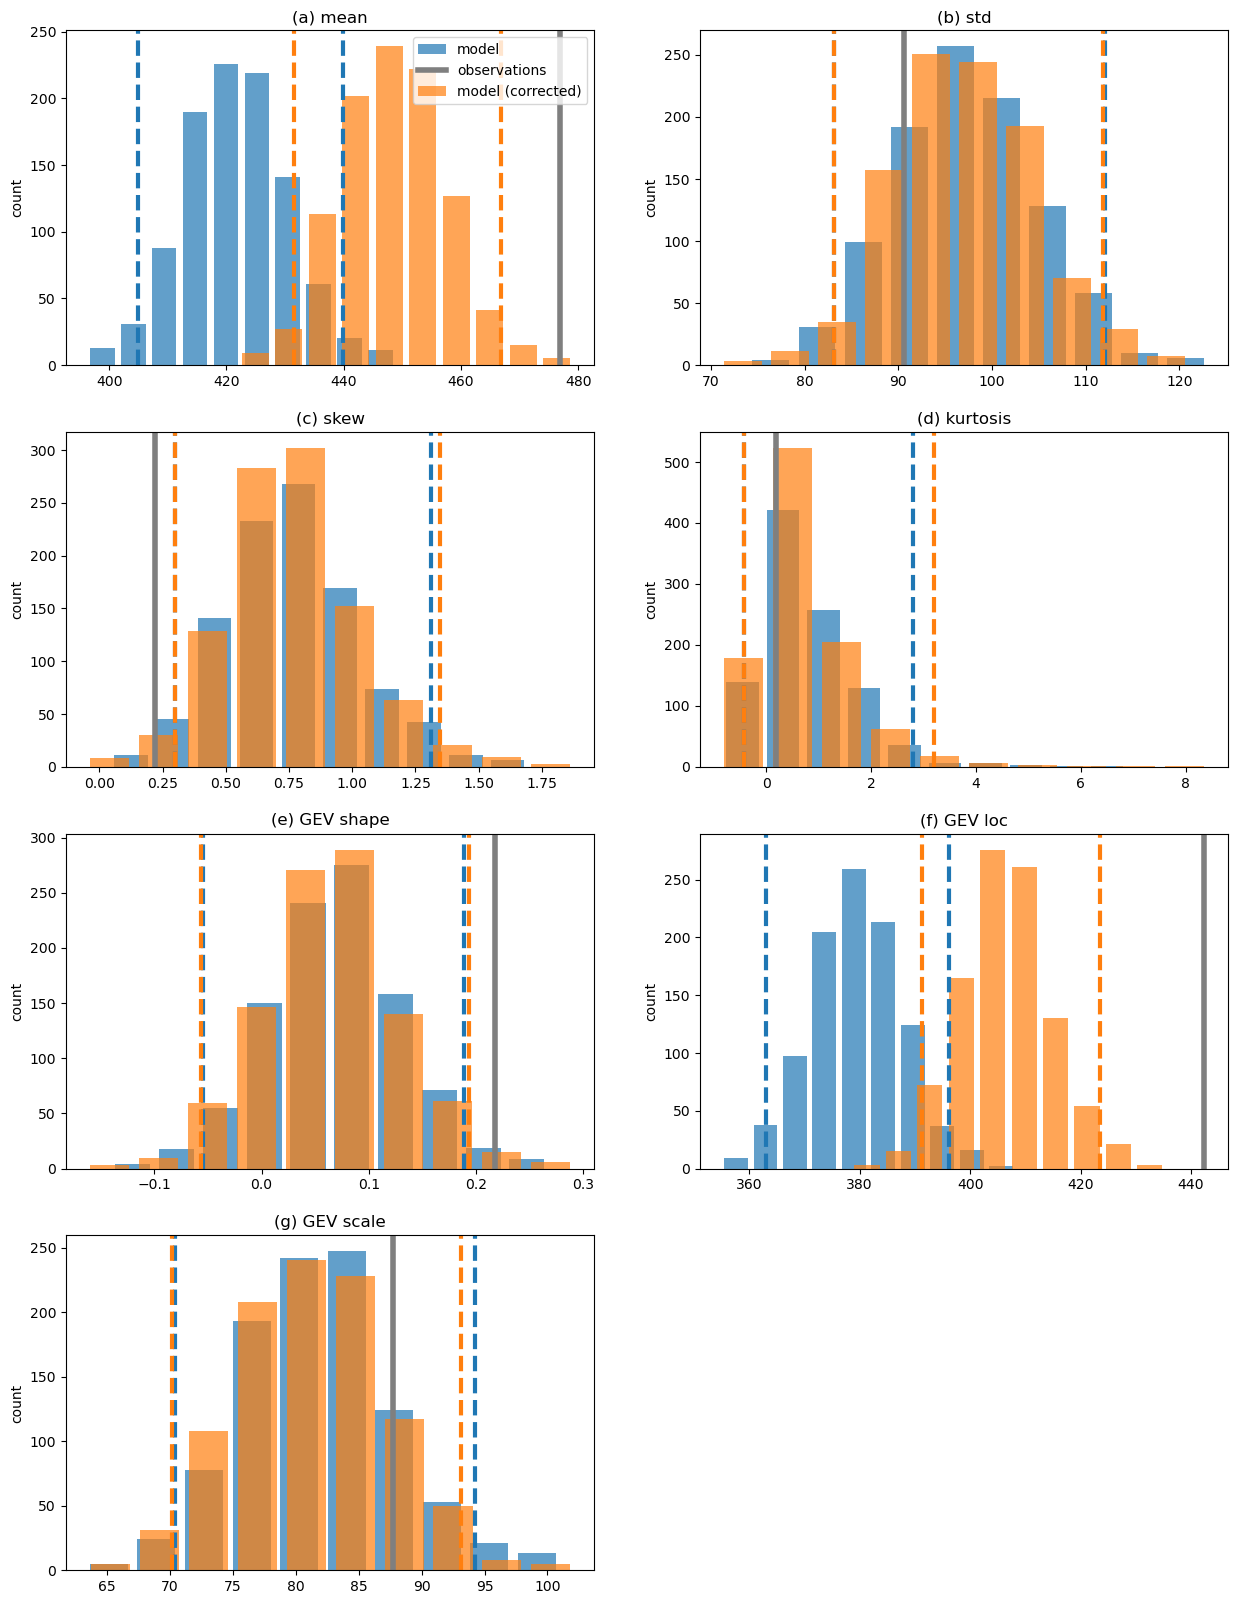

In [57]:
moments.create_plot(
    cafe_da_indep,
    agcd_ds['pr'],
    da_bc_fcst=cafe_da_bc,
    outfile='wheatbelt_moments.png',
)

In [36]:
similarity_ds = similarity.similarity_tests(cafe_da_bc, agcd_ds, 'pr')

In [32]:
print(similarity_ds['ks_statistic'].values)

0.20944034


In [31]:
print(similarity_ds['ks_pval'].values)

3.2741635e-05


In [33]:
print(similarity_ds['ad_statistic'].values)

9.51975


/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/xstatstests/scipy.py:246: UserWarning: p-value floored: true value smaller than 0.001
  outputs = func(args, **scipy_kwargs)


In [34]:
print(similarity_ds['ad_pval'].values)

0.001


## Results

In [65]:
cafe_da_bc_stacked = cafe_da_bc.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [66]:
print(cafe_da_bc_stacked)

<xarray.DataArray 'pr' (sample: 34944)>
array([474.3500212 , 712.58423603, 430.21373363, ..., 412.08487005,
       548.11990739, 475.25507601])
Coordinates:
    time       (sample) object 1998-05-01 12:00:00 ... 2029-11-01 12:00:00
  * sample     (sample) object MultiIndex
  * ensemble   (sample) int64 1 1 1 1 1 1 1 1 1 1 ... 96 96 96 96 96 96 96 96 96
  * init_date  (sample) object 1995-05-01 00:00:00 ... 2020-11-01 00:00:00
  * lead_time  (sample) int64 3 4 5 6 7 8 9 3 4 5 6 7 ... 6 7 8 9 3 4 5 6 7 8 9
Attributes:
    units:                   mm yr-1
    bias_correction_method:  additive
    bias_correction_period:  2004-01-01-2019-12-31


In [60]:
pr2019 = agcd_ds['pr'].data.min()
print(pr2019)

241.9741


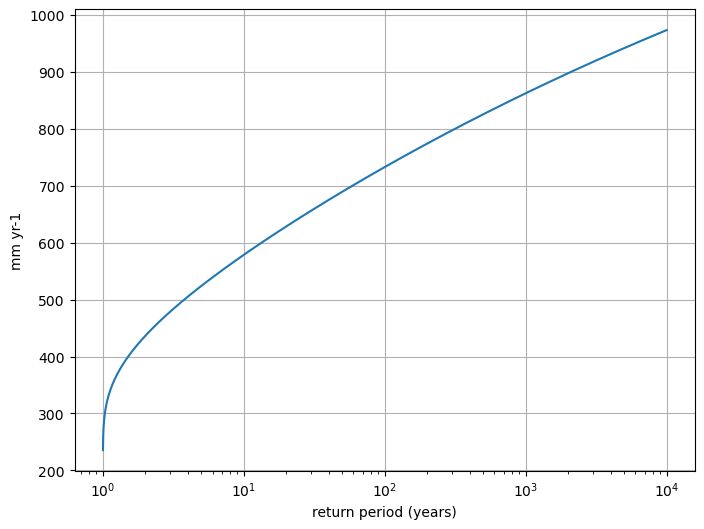

In [67]:
stability.plot_return(cafe_da_bc_stacked, 'gev')

In [68]:
n_events_bc, n_population_bc, return_period_bc, percentile_bc = general_utils.event_in_context(
    cafe_da_bc_stacked.values,
    pr2019,
    'below',
)
print('BIAS CORRECTED DATA')
print(f'{n_events_bc} events in {n_population_bc} samples')
print(f'{percentile_bc:.2f}% percentile')
print(f'{return_period_bc:.0f} year return period')

BIAS CORRECTED DATA
52 events in 34944 samples
0.15% percentile
672 year return period
